In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import Model
from keras import backend as K
from keras.optimizers import SGD
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import (ImageDataGenerator, Iterator,
                                       array_to_img, img_to_array, load_img)
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.optimizers import SGD, Adam
import sys, os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
tf.__version__

'2.2.0'

In [3]:
%matplotlib inline

In [4]:
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

### Data Generator

In [5]:
train_data_dir = '../data/CollisionData/'

img_width, img_height = 224, 224
nb_train_samples = 730 
nb_validation_samples = 181
epochs = 10
batch_size = 16

if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3) 

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    ) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    subset='validation') # set as validation data

Found 730 images belonging to 2 classes.
Found 181 images belonging to 2 classes.


### Model Architecture
Inception V3

Using imagenet weights as initialization. The entire architecture is retrainable.

In [7]:
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = True #change this to False is retraining is not to be done in base layers

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(1, activation='sigmoid')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

base_model = InceptionV3(weights='imagenet', 
                      include_top=False, 
                      input_shape=input_shape)

class_list = ['CollisionOrClose', 'NoCollision']
FC_LAYERS = [256, 256]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

In [8]:
adam = Adam(lr=0.00001)
finetune_model.compile(adam, loss='binary_crossentropy', metrics=['accuracy'])

filepath="./checkpoints/" + "Inceptionv3" + "_model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]

In [9]:
finetune_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Training and Testing

In [10]:
history = finetune_model.fit_generator(train_generator, 
    steps_per_epoch = nb_train_samples // batch_size, 
    epochs = epochs, validation_data = validation_generator, 
    validation_steps = nb_validation_samples // batch_size, shuffle=True,) 

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
45/45 [==============================] - 17s 368ms/step - accuracy: 0.7143 - loss: 0.6202 - val_accuracy: 0.7670 - val_loss: 0.5590
Epoch 2/10
45/45 [==============================] - 15s 339ms/step - accuracy: 0.7829 - loss: 0.4804 - val_accuracy: 0.7841 - val_loss: 0.3616
Epoch 3/10
45/45 [==============================] - 15s 338ms/step - accuracy: 0.8137 - loss: 0.3902 - val_accuracy: 0.8636 - val_loss: 0.2519
Epoch 4/10
45/45 [==============================] - 15s 337ms/step - accuracy: 0.8389 - loss: 0.3520 - val_accuracy: 0.9205 - val_loss: 0.1697
Epoch 5/10
45/45 [==============================] - 15s 339ms/step - accuracy: 0.8711 - loss: 0.3138 - val_accuracy: 0.9318 - val_loss: 0.1813
Epoch 6/10
45/45 [==============================] - 15s 339ms/step - accuracy: 0.8880 - loss: 0.2723 - val_accuracy: 0.9261 - val_loss: 0.1913
Epoch 7/10
45/45 [==============================] - 15s 341ms/step

### Performance

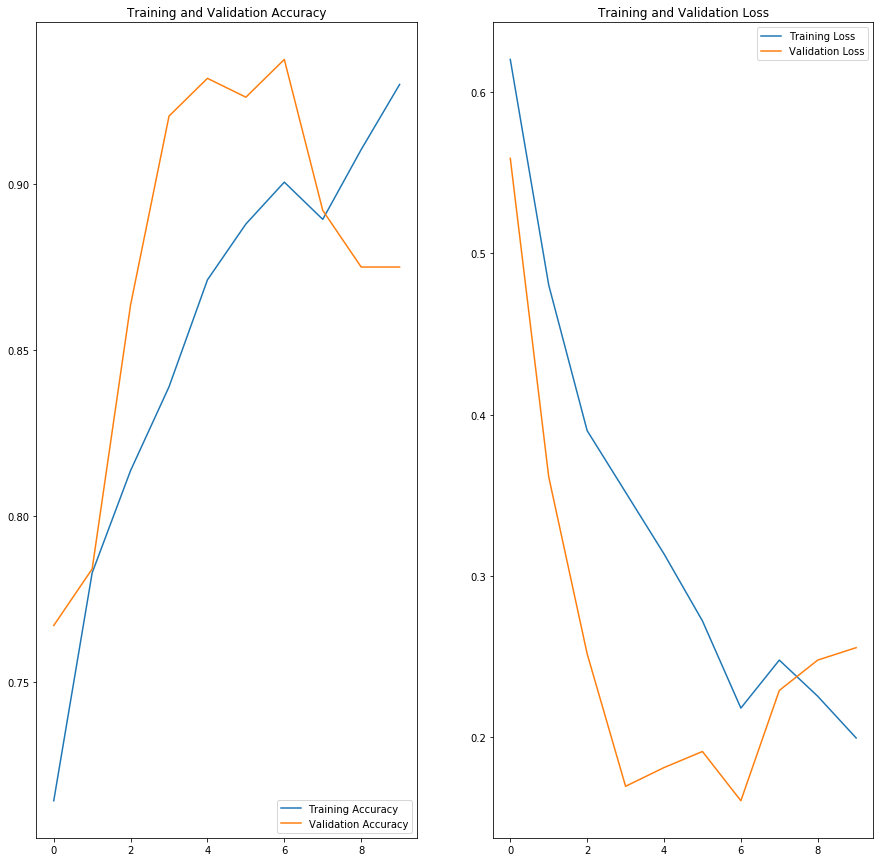

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
from sklearn.metrics import confusion_matrix


probabilities = finetune_model.predict_generator(generator=validation_generator)
print(probabilities)

Instructions for updating:
Please use Model.predict, which supports generators.
[[0.02643947]
 [0.01328972]
 [0.01231207]
 [0.01128927]
 [0.20508097]
 [0.13116543]
 [0.06494446]
 [0.0431268 ]
 [0.05997844]
 [0.02531045]
 [0.05025949]
 [0.13934264]
 [0.03483645]
 [0.09084677]
 [0.17488745]
 [0.05956416]
 [0.3058183 ]
 [0.0590676 ]
 [0.07210004]
 [0.3958099 ]
 [0.03577117]
 [0.01952932]
 [0.1471051 ]
 [0.0873444 ]
 [0.12362941]
 [0.85240316]
 [0.12080538]
 [0.032728  ]
 [0.17851919]
 [0.08017301]
 [0.10921347]
 [0.6140345 ]
 [0.0247795 ]
 [0.47472718]
 [0.01736981]
 [0.12491202]
 [0.02713673]
 [0.02985671]
 [0.0370333 ]
 [0.05368432]
 [0.10312217]
 [0.96397525]
 [0.9676567 ]
 [0.99177283]
 [0.8590875 ]
 [0.8700715 ]
 [0.89850396]
 [0.9833746 ]
 [0.9734741 ]
 [0.9990496 ]
 [0.9811323 ]
 [0.9905449 ]
 [0.85614634]
 [0.96592706]
 [0.9500822 ]
 [0.9443043 ]
 [0.9965946 ]
 [0.96331304]
 [0.9471915 ]
 [0.9385432 ]
 [0.9643854 ]
 [0.905544  ]
 [0.9868146 ]
 [0.97356975]
 [0.93319756]
 [0.993932

In [13]:
y_true = validation_generator.classes
y_pred = probabilities > 0.5
class_labels = list(validation_generator.class_indices.keys())  

In [14]:
report = metrics.classification_report(y_true, y_pred, target_names=class_labels)
print(report)  

                  precision    recall  f1-score   support

     NoCollision       0.65      0.95      0.77        41
CollisionOrClose       0.98      0.85      0.91       140

        accuracy                           0.87       181
       macro avg       0.82      0.90      0.84       181
    weighted avg       0.91      0.87      0.88       181



In [15]:
mat = confusion_matrix(y_true, y_pred)
print(mat)

[[ 39   2]
 [ 21 119]]


### Analyze Results

In [16]:
def plotImages1(images_arr, y1, y2, row_size):
    fig, axes = plt.subplots(1, row_size, figsize=(20,20))
    axes = axes.flatten()
    for img, l, p, ax in zip(images_arr, y1, y2, axes):
        ax.imshow(img)
        ax.set_title("Label:"+str(int(l))+", Pred:"+str(int(p)))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

<Figure size 1440x1440 with 0 Axes>

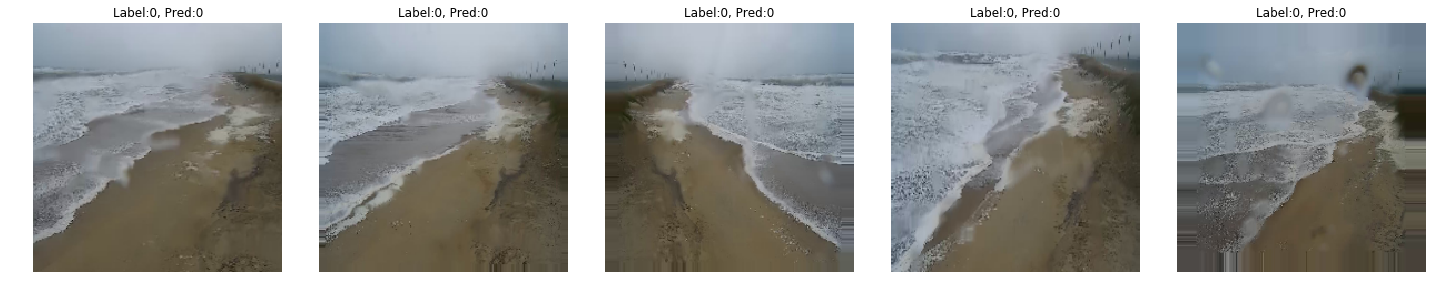

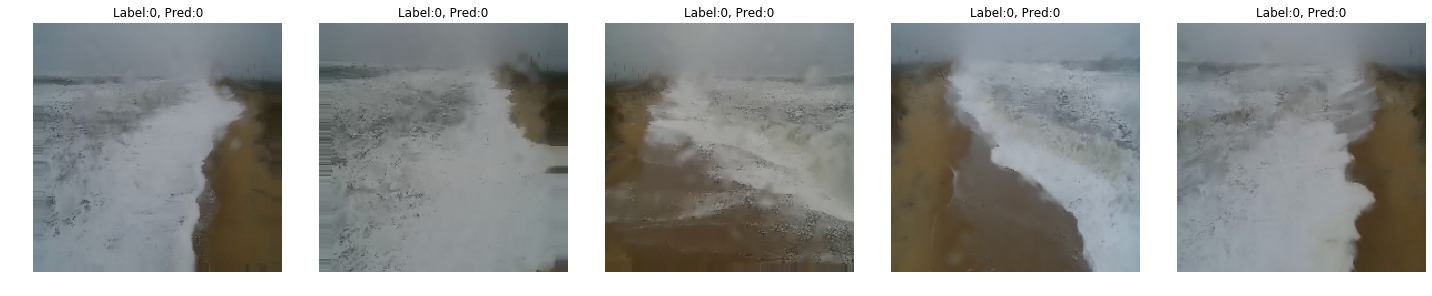

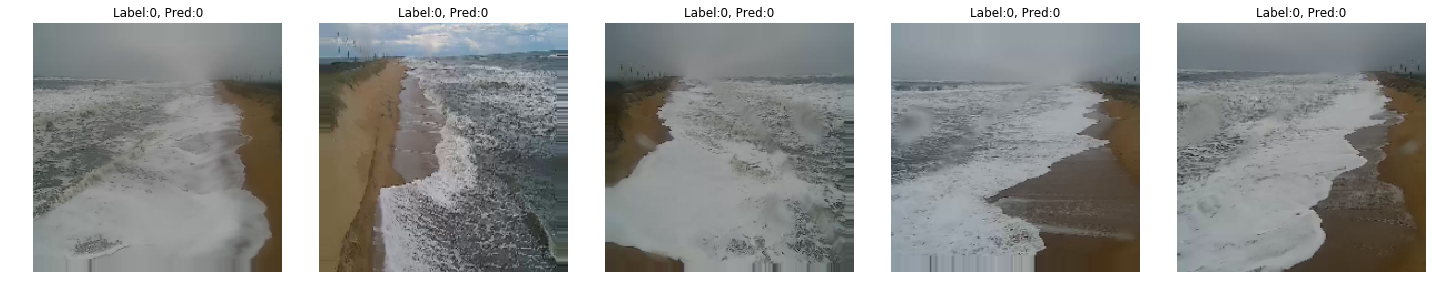

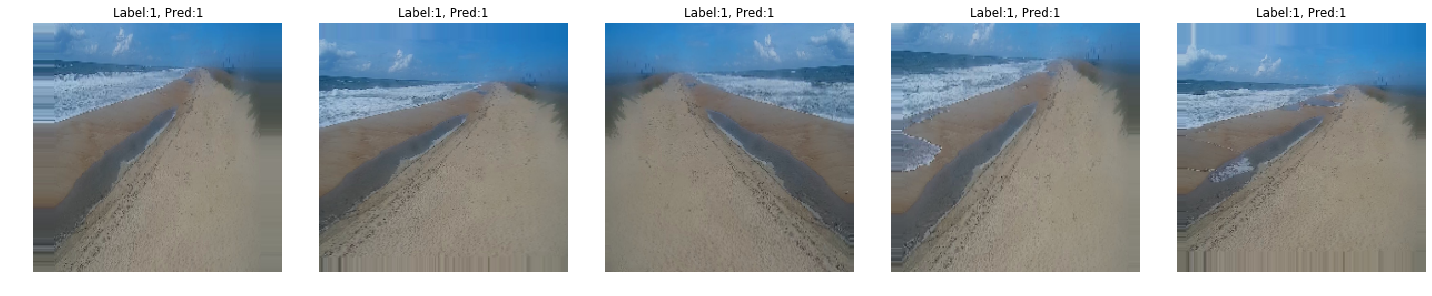

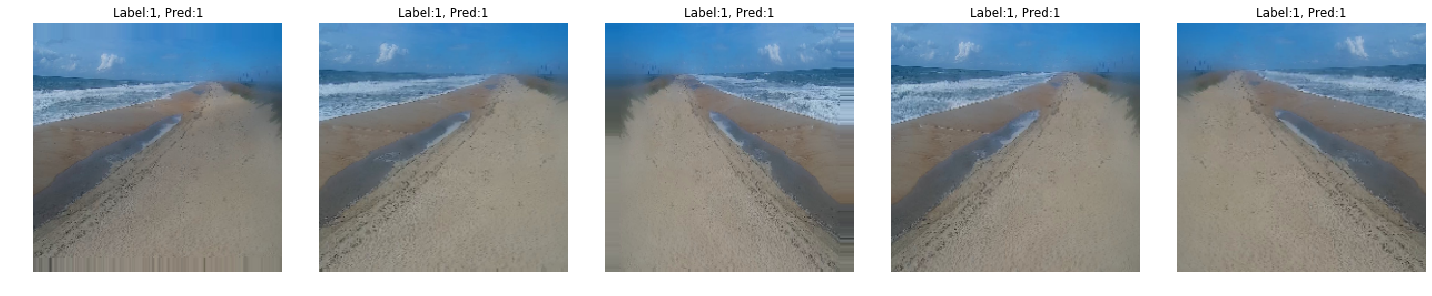

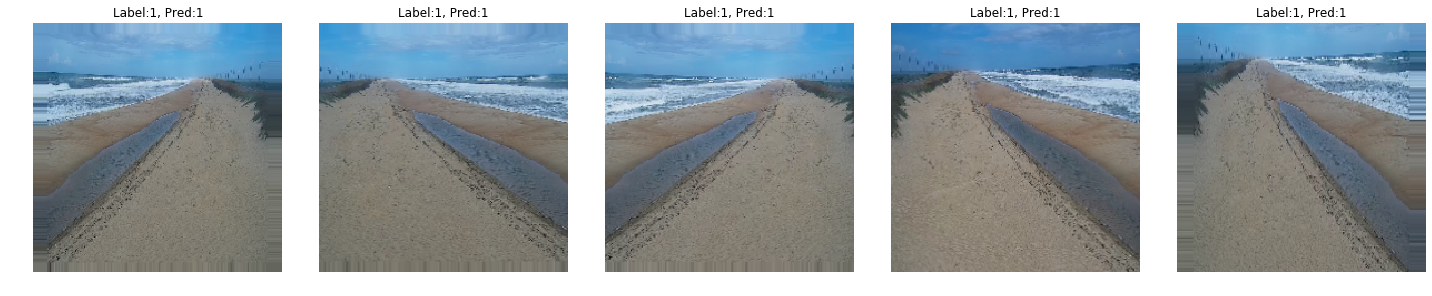

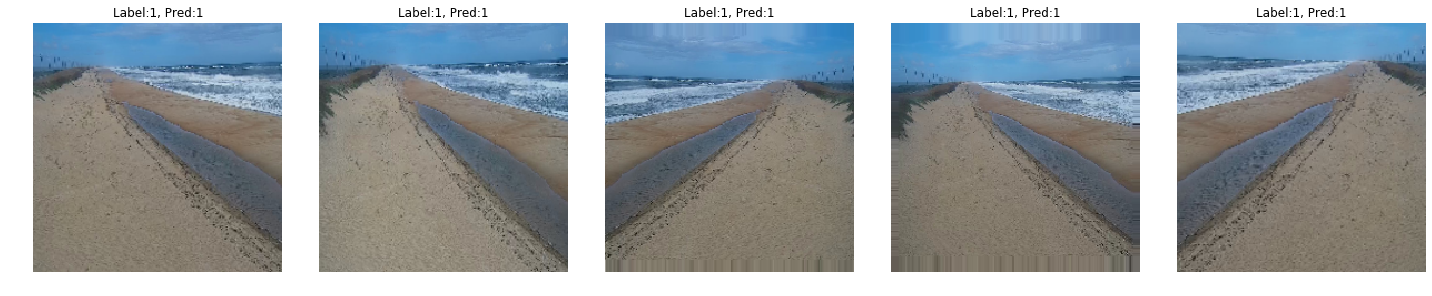

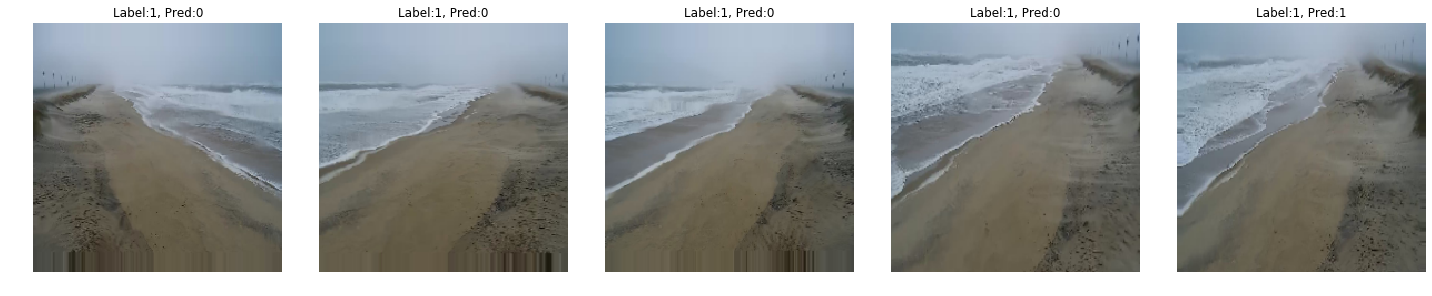

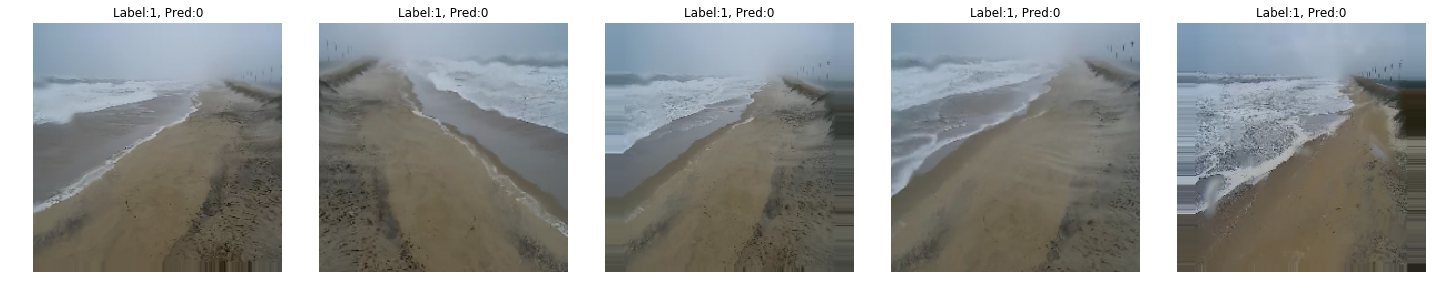

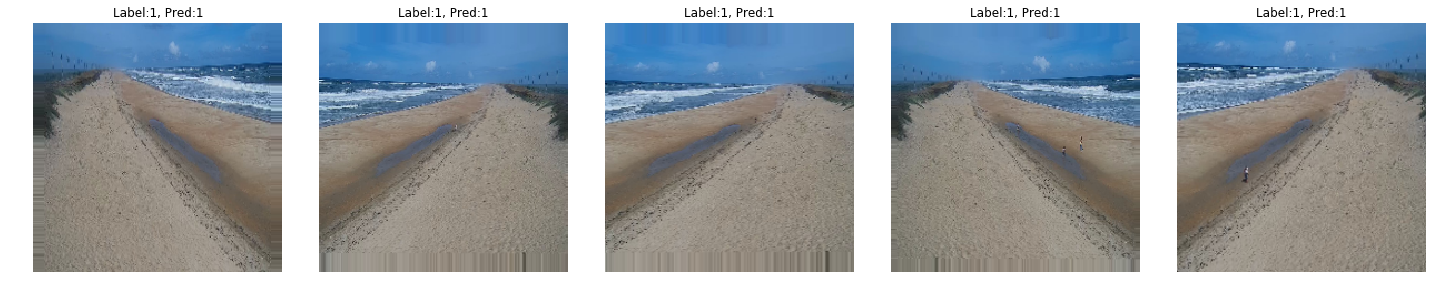

In [17]:
cnt = 0
row_size = 5
validation_generator.reset()
fig=plt.figure(figsize=(20,20))

ax = []
for i in range(10):
    x,y = next(validation_generator)
    img = x[:row_size]
    y_label = y[:row_size]
    y_predicted = y_pred[cnt:cnt+row_size]
    plotImages1(img, y_label, y_predicted, row_size)
    cnt += 16

In [18]:
labels = (validation_generator.class_indices)

In [19]:
labels

{'CollisionOrClose': 0, 'NoCollision': 1}